# Loading Libraries

In [1]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import imageio

In [2]:
from matplotlib import pyplot as plt

In [3]:
from skimage.filters import threshold_otsu

In [4]:
import seaborn as sns
sns.set_style("darkgrid")

# Utility Functions

In [5]:
def load_data(path):
    """ X = Images and Y = masks """

    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    mask_x =  sorted(glob(os.path.join(path, "training", "mask", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))
    return (train_x, mask_x,train_y)

In [6]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
def adjust_gamma(image, gamma=1.0):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

In [8]:
def adjust_square(image, gamma=1.0):
    table = np.array([[i**2 for i in row] for row in image]).astype("uint16")
    return table

In [9]:
def square_rescale(image):
    table = np.array([[i//(256) for i in row] for row in image]).astype("uint16")
    return table

# Loading The Data Set

In [10]:
""" Seeding """
np.random.seed(42)

""" Load the data """
data_path = "D:\\Data sets\\DRIVE"
(train_x, mask_x, train_y) = load_data(data_path)

print(f"Train: {len(train_x)} - {len(train_y)} - {len(mask_x)}")


Train: 20 - 20 - 20


# Square Transformation

In [72]:
x = train_x[0]
y = train_y[0]
m = mask_x[0]
""" Reading image and mask """
src = cv2.imread(x, cv2.IMREAD_COLOR)
mask  = cv2.imread(m, cv2.IMREAD_COLOR)
y = imageio.mimread(y)[0]

x = src[:,:,1]
m = mask[:,:,1]


<AxesSubplot:ylabel='Count'>

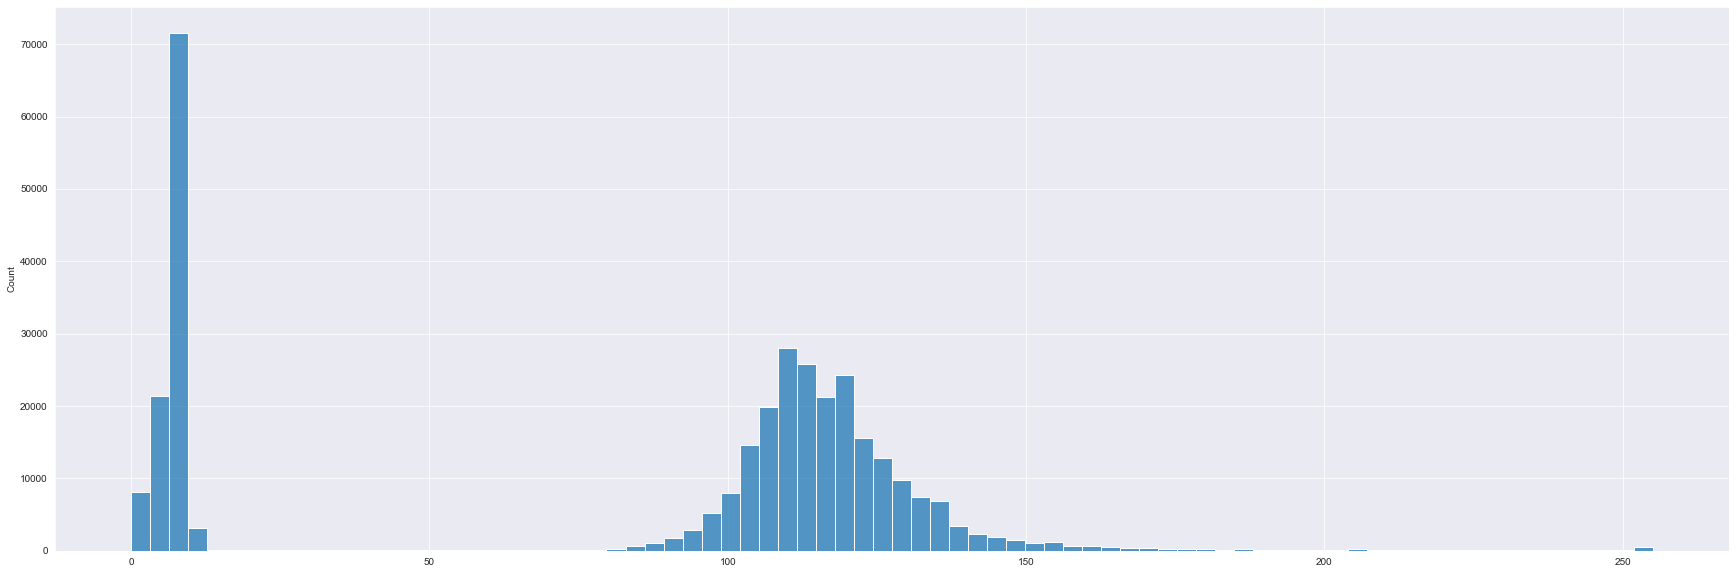

In [73]:
plt.figure(figsize=(30,10))
sns.histplot(data= x.ravel())

In [184]:
h = adjust_gamma(x, gamma=0.4)

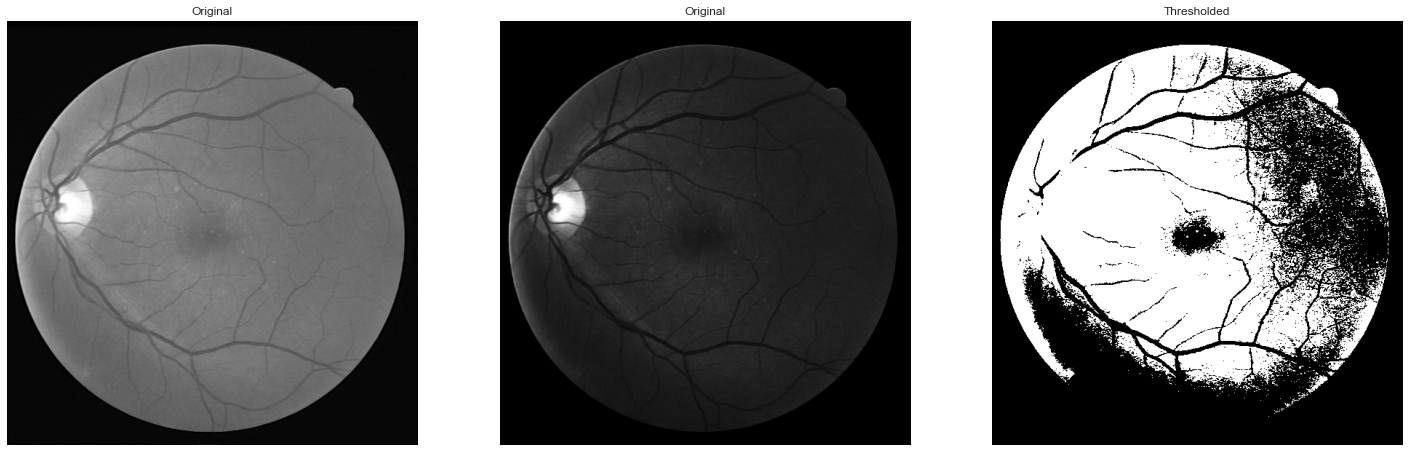

In [195]:
binary = h > 31

fig, axes = plt.subplots(ncols=3, figsize=(25, 25))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(x, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')
ax[1].imshow(h, cmap=plt.cm.gray)
ax[1].set_title('Original')
ax[1].axis('off')
ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')
plt.show()


In [186]:
image = h#cv2.GaussianBlur(h, (5, 5), 0)

In [187]:
# Set total number of bins in the histogram
bins_num = 256

# Get the image histogram
hist, bin_edges = np.histogram(image, bins=bins_num)
hist, bin_edges = np.histogram(h, bins=bins_num)
histM, bin_edges = np.histogram(m, bins=bins_num)
# Get normalized histogram if it is required



In [188]:
#hist = np.divide(hist.ravel(), hist.max())
hist = hist.ravel()
histM = histM.ravel()

In [189]:
hist, histM

(array([104742,    205,    145,     84,     68,     77,     91,     54,
            62,     65,     69,     47,     49,     75,    219,    228,
           447,    687,    923,   1276,    815,   2115,   3104,   4563,
          2606,   5981,   3480,   7995,   5349,  14510,   8853,  19160,
          9230,   8609,  15484,   7115,   6586,  12666,   5969,   5598,
          5468,   5137,   9490,   4281,   4032,   3516,   3239,   2984,
          2739,   2476,   2196,   2046,   3478,   1383,   1250,   1162,
           968,    834,      0,    797,    717,    665,    590,    589,
           501,    518,    413,    401,    371,    363,      0,    351,
           334,    295,    285,    267,      0,    233,    219,    218,
           201,      0,    200,    189,    176,    158,      0,    138,
           115,    121,      0,    138,    112,    100,      0,    101,
           107,      0,     77,     92,     72,      0,     72,     65,
             0,     53,     66,      0,     62,     45,      0, 

In [190]:
hist[0], histM[0]

(104742, 104360)

In [191]:
hist[0] = 0
hist[1] = 0#max(hist[1] - histM[1], 0)
hist[2] = 0#max(hist[2] - histM[2], 0)
hist[3] = 0#max(hist[3] - histM[3], 0)
hist[4] = 0#max(hist[4] - histM[4], 0)

In [192]:
hist

array([    0,     0,     0,     0,     0,    77,    91,    54,    62,
          65,    69,    47,    49,    75,   219,   228,   447,   687,
         923,  1276,   815,  2115,  3104,  4563,  2606,  5981,  3480,
        7995,  5349, 14510,  8853, 19160,  9230,  8609, 15484,  7115,
        6586, 12666,  5969,  5598,  5468,  5137,  9490,  4281,  4032,
        3516,  3239,  2984,  2739,  2476,  2196,  2046,  3478,  1383,
        1250,  1162,   968,   834,     0,   797,   717,   665,   590,
         589,   501,   518,   413,   401,   371,   363,     0,   351,
         334,   295,   285,   267,     0,   233,   219,   218,   201,
           0,   200,   189,   176,   158,     0,   138,   115,   121,
           0,   138,   112,   100,     0,   101,   107,     0,    77,
          92,    72,     0,    72,    65,     0,    53,    66,     0,
          62,    45,     0,    58,    52,     0,    62,    65,     0,
          58,     0,    58,    50,     0,    59,    47,     0,    55,
           0,    64,

In [193]:
hist.max(), hist.argmax()

(19160, 31)

In [194]:
hist = np.divide(hist.ravel(), hist.max())

In [164]:

# Calculate centers of bins
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

# Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# Get the class means mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1
# Get the class means mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)

threshold = bin_mids[:-1][index_of_max_val]
print("Otsu's algorithm implementation thresholding result: ", threshold)

Otsu's algorithm implementation thresholding result:  0.498046875


<ipython-input-164-9cd5d49d986f>:9: RuntimeWarning: invalid value encountered in true_divide
  mean1 = np.cumsum(hist * bin_mids) / weight1


In [165]:
hist.max()

1.0

# Graphical Reprisentation

<AxesSubplot:ylabel='Count'>

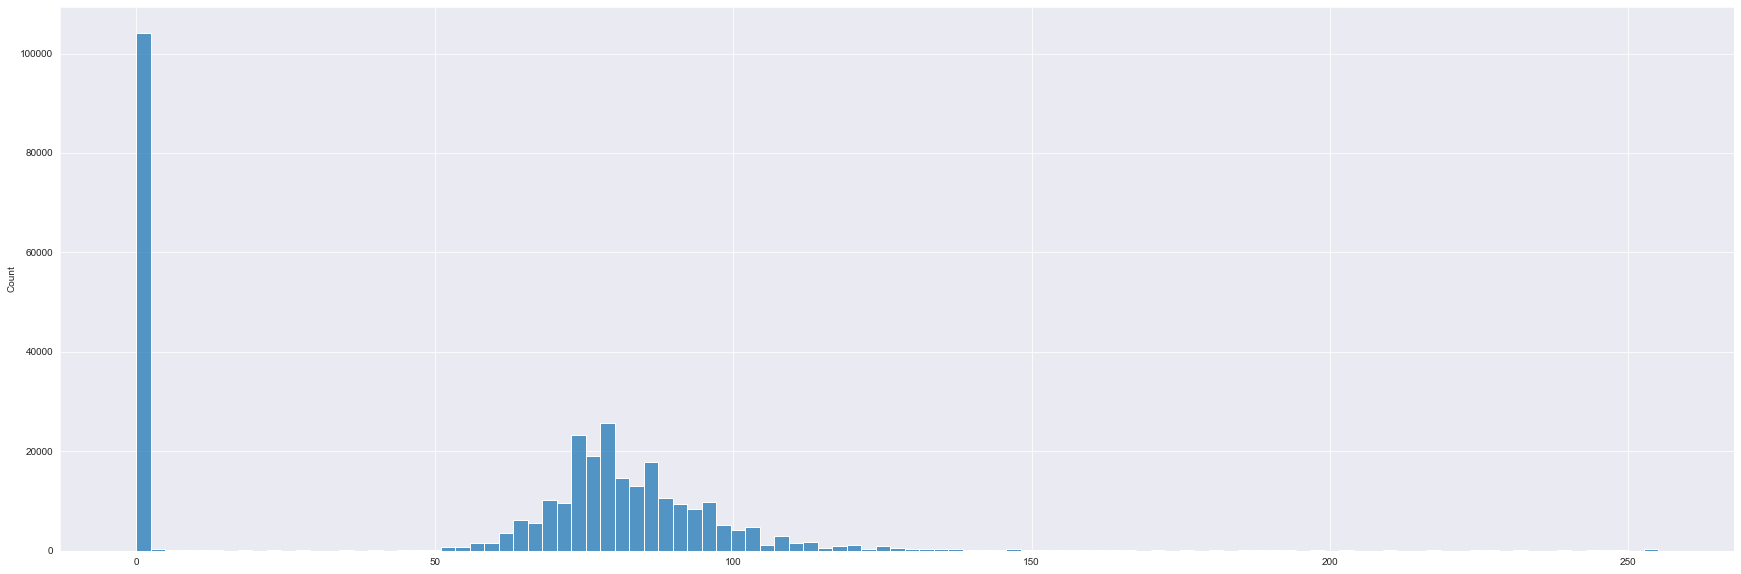

In [166]:
plt.figure(figsize=(30,10))
sns.histplot(data= h.ravel())

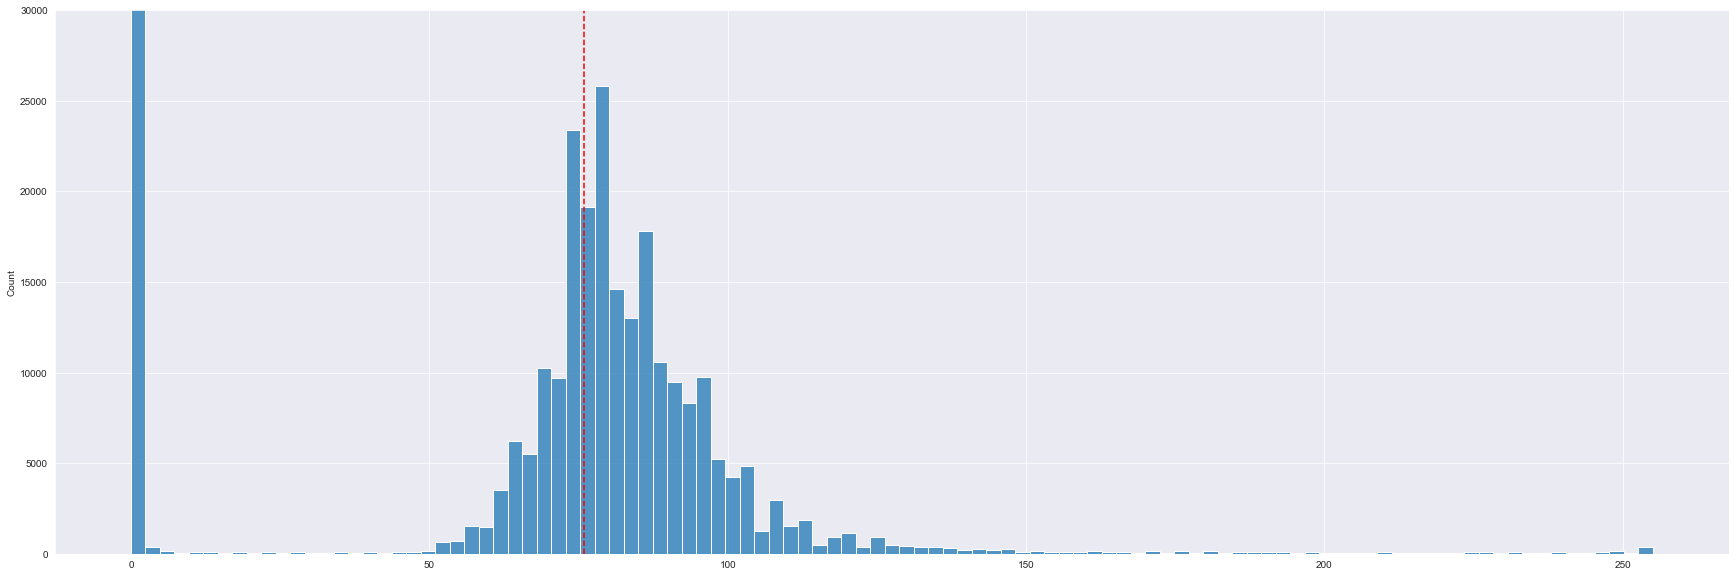

In [167]:
plt.figure(figsize=(30,10))
fig = sns.histplot(data= h.ravel())
fig.set(ylim=(0, 30000))
#fig.set(xlim=(0, 60000))
fig.axvline(76, ls='--', c='red')